In [1]:


import rasterio as rio
import rasterio.mask
import fiona
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr
from shapely.geometry import Point
from shapely.geometry import LineString
import hvplot.xarray  # noqa
import cartopy.crs as crs
import hvplot.pandas
import h5py


In [25]:
#633 dzdt - huw processed, 33 is earlier release without corresctions but huw applied version 34 corrections to it
# GLAH - wei ji says this one good
# GLAHPY - wei ji processed but cant remember how, maybe dont use.

# paths = glob.glob('/Volumes/arc_02/REMOTE_SENSING/ICESAT/GLAH12.034/**/*.H5')

# path = paths[0]
# ds = xr.open_dataset(path, engine="h5netcdf")

path = '/Volumes/arc_02/REMOTE_SENSING/ICESAT/GLA12_633_DZDT/633_all_dzdt.txt'

df = pd.read_csv(path,skiprows=1,delim_whitespace=True,
                 names=['x', 'y', 'z', 'lat', 'lon', 'elevation', 'bin_dzdt', 'grad_x', 'grad_y', 'range'])


In [3]:
df

x          y          z        lat         lon  elevation  \
0        1093594.60 -2195552.3 -51.946918 -67.699427  153.522310 -51.946918   
1        1093097.90 -2193667.8 -52.174319 -67.716359  153.513060 -52.174319   
2        1092845.20 -2192684.3 -52.192854 -67.725169  153.508100 -52.192854   
3        1092729.70 -2192200.4 -52.048455 -67.729469  153.505470 -52.048455   
4        1092597.60 -2191661.9 -52.085004 -67.734269  153.502610 -52.085004   
...             ...        ...        ...        ...         ...        ...   
3818516   598763.60  2232597.7  15.148624 -68.956030   15.012949  15.148624   
3818517   598786.50  2233106.8  15.110570 -68.951596   15.010229  15.110570   
3818518   598798.69  2233593.3  48.426021 -68.947382   15.007399  48.426021   
3818519   598816.68  2234085.5  45.499696 -68.943105   15.004672  45.499696   
3818520   598822.04  2234610.8  14.962812 -68.938574   15.001433  14.962812   

         bin_dzdt    grad_x    grad_y       range  
0       -0.000125 -0.001797 -0.000190    1.297918  
1       -0.000266 -0.000033  0.000321    0.918130  
2       -0.000133  0.001753  0.000748    0.971914  
3        0.000010 -0.000302 -0.000310    1.403095  
4       -0.000248 -0.000525  0.000086    1.288685  
...           ...       ...       ...         ...  
3818516  0.000063  0.001541 -0.000032    1.259415  
3818517  0.000251  0.000182 -0.000185    1.355445  
3818518  0.009768 -0.148879  0.242917  742.763600  
3818519  0.008042 -0.198031 -0.144738  757.994300  
3818520 -0.000034 -0.000157 -0.000409    0.876738  

[3818521 rows x 10 columns]

In [4]:
line_name='line7'
gdf_line7 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
# study_area = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/PRE_FIELD/KISRoutes/study_area_buffer.shp')
line_name='line6'
gdf_line6 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
# study_area = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/PRE_FIELD/KISRoutes/study_area_buffer.shp')
line_name='line5'
gdf_line5 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
# study_area = gpd.read_file('/Users/home/whitefar/DATA/FIELD_ANT_19/PRE_FIELD/KISRoutes/study_area_buffer.shp')
line_name='line4'
gdf_line4 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")

line_name='line3'
gdf_line3 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
line_name='line2'
gdf_line2 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")
line_name='line1'
gdf_line1 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")

line_name='line0'
gdf_line0 = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                        +line_name+".shp")

In [5]:
melt = Point(-380650, -725450)
accr = Point(-377950,-729050)
min_x = gdf_line7.geometry.x.min()
max_x = gdf_line0.geometry.x.max()
min_y = gdf_line0.geometry.y.min()
max_y = gdf_line7.geometry.y.max()

In [36]:
df = df.query(expr="x > -382064.5722209641 & x < -374781.1654740692 & y > -734075.0820404041 & y < -722764.4514729496")
df.reset_index(drop=True,inplace=True)

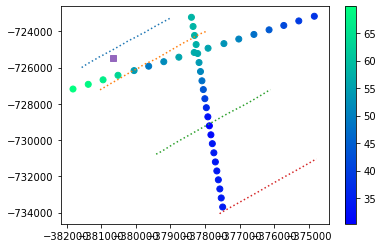

In [37]:
plt.scatter(df.x,df.y,c=df.z,cmap='winter')
plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,':')
plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,':')

plt.plot(gdf_line3.geometry.x,gdf_line3.geometry.y,':')
plt.plot(gdf_line0.geometry.x,gdf_line0.geometry.y,':')
plt.plot(melt.xy[0],melt.xy[1],'s')
plt.plot(accr.xy[0],accr.xy[1])
plt.colorbar()

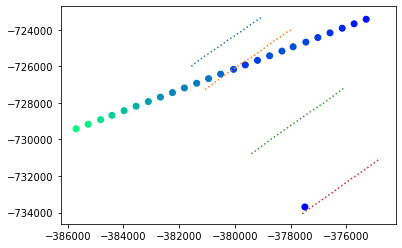

In [33]:
f =21
t = -1
plt.scatter(df.x.iloc[f:t],df.y.iloc[f:t],c=df.z.iloc[f:t],cmap='winter')
plt.plot(gdf_line7.geometry.x,gdf_line7.geometry.y,':')
plt.plot(gdf_line6.geometry.x,gdf_line6.geometry.y,':')
plt.plot(gdf_line3.geometry.x,gdf_line3.geometry.y,':')
plt.plot(gdf_line0.geometry.x,gdf_line0.geometry.y,':')

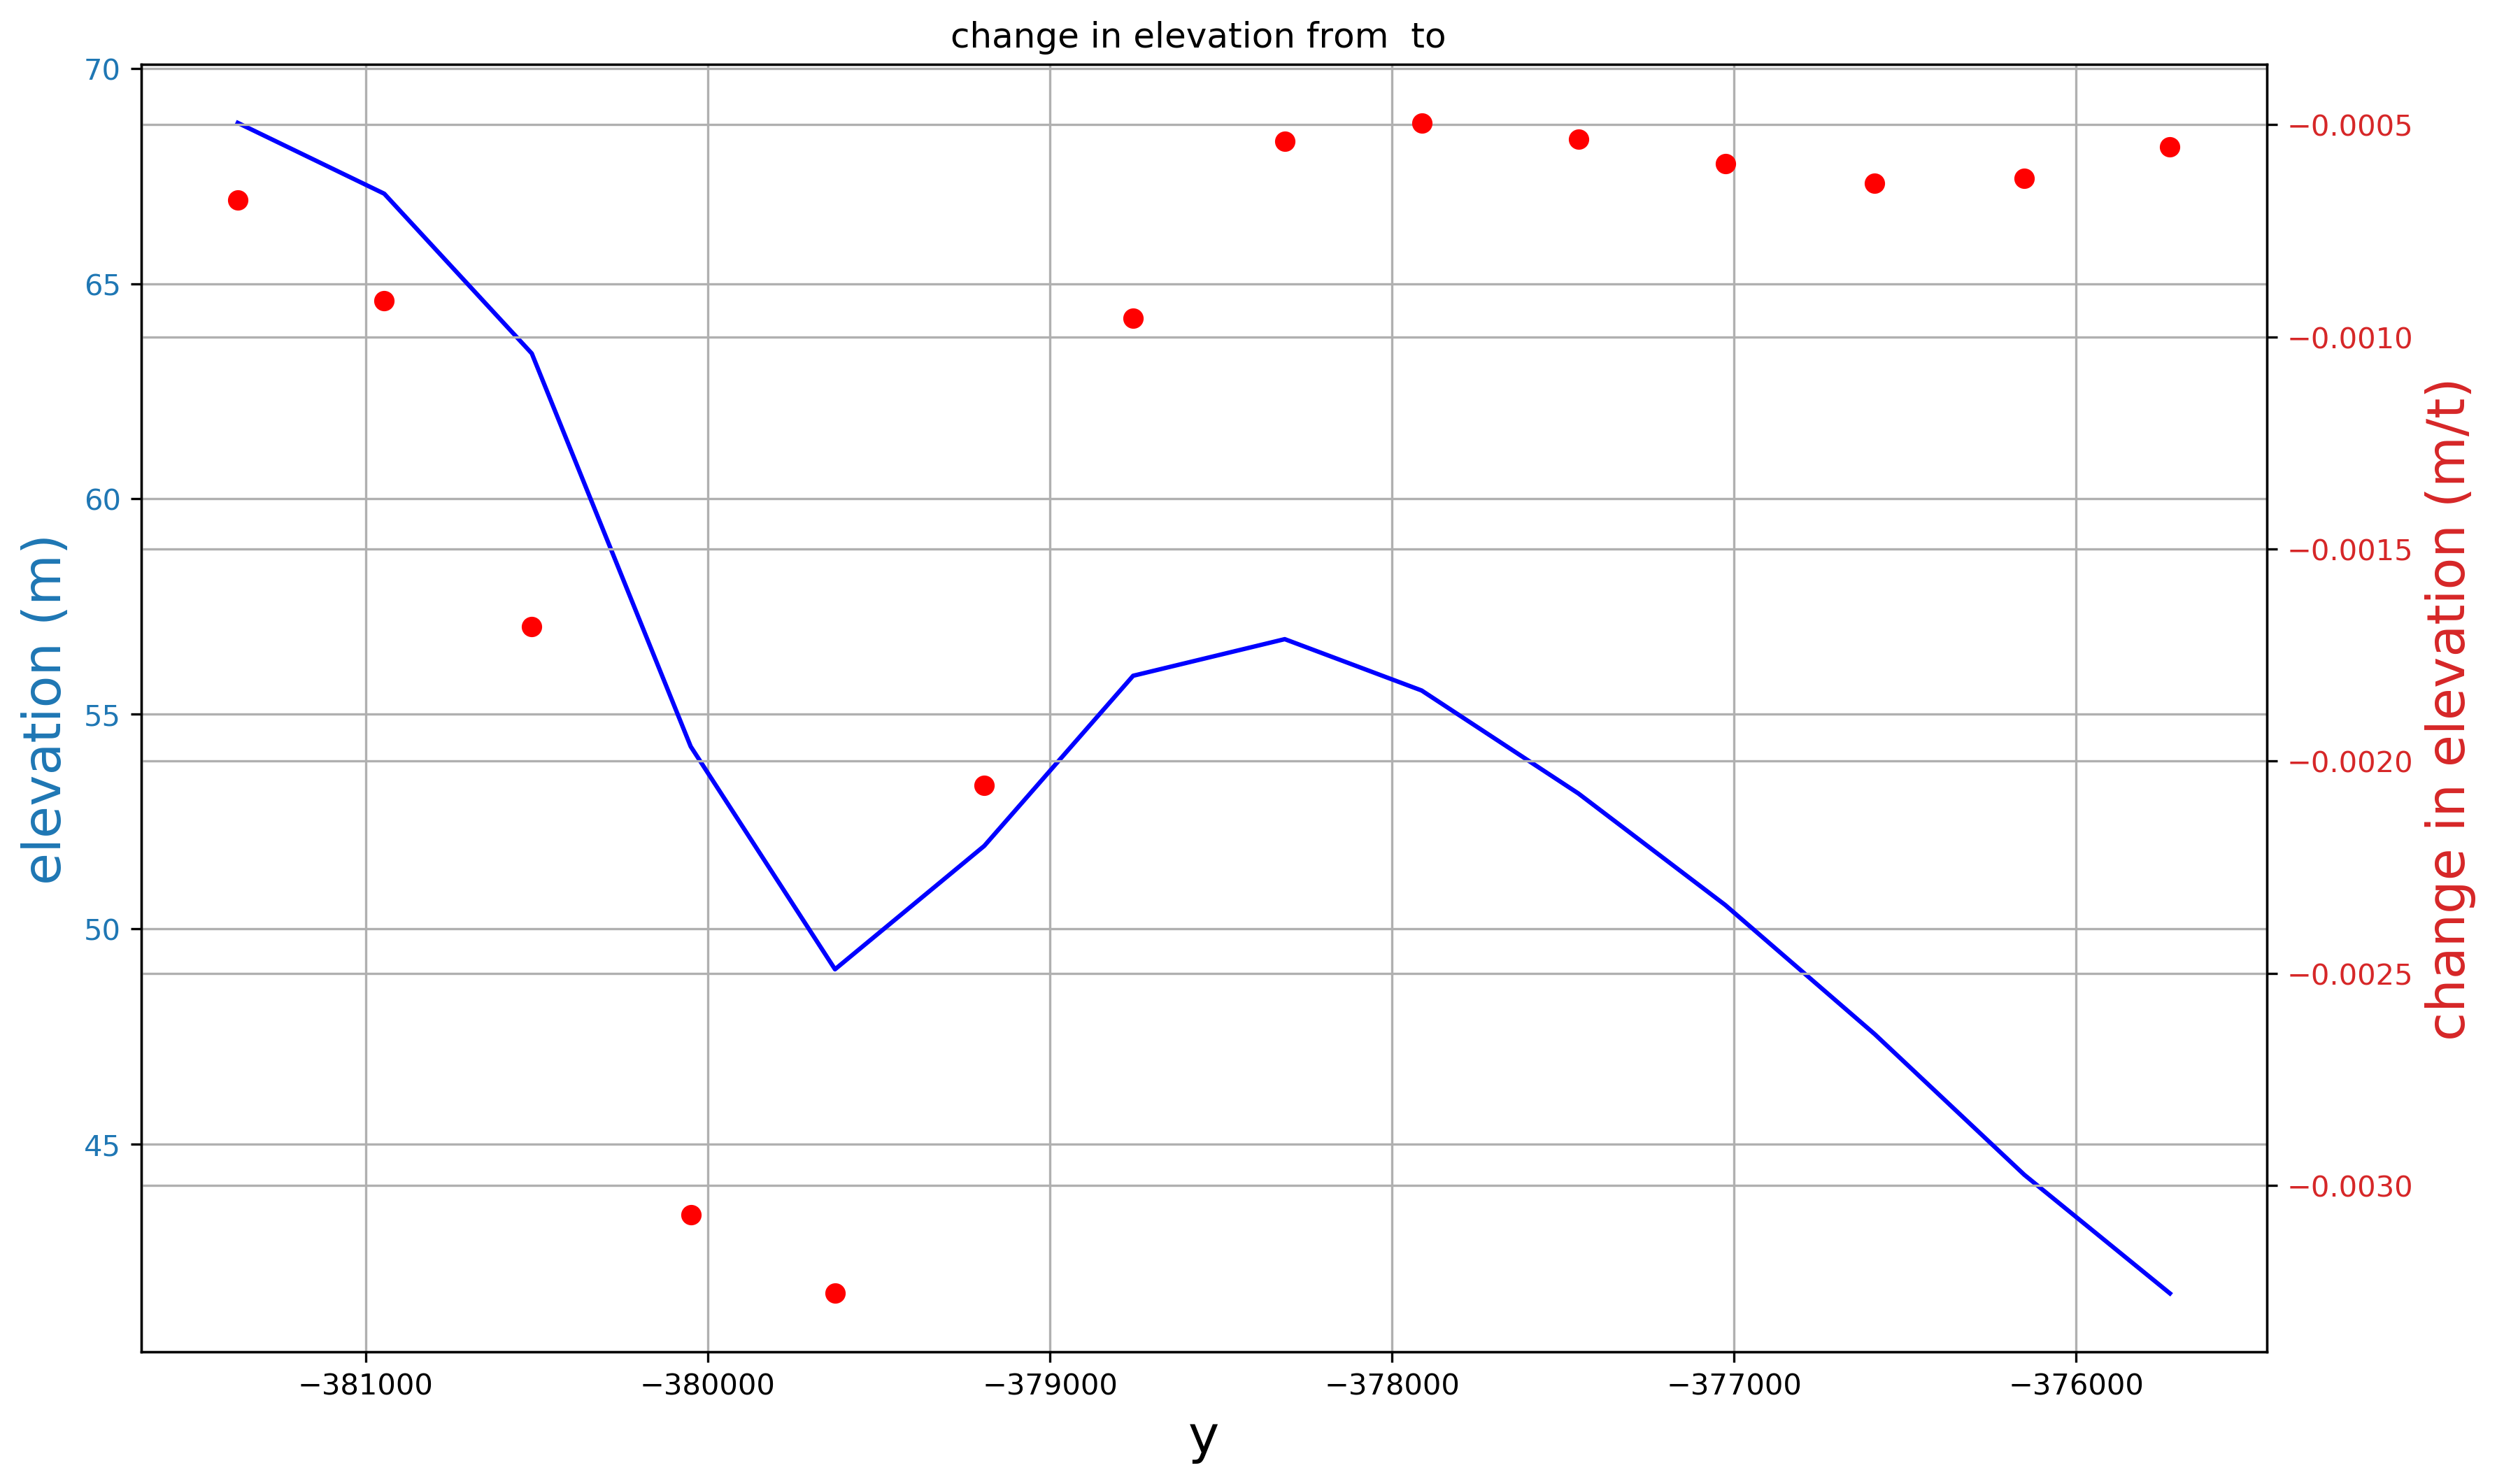

In [66]:
fig, ax1 = plt.subplots(figsize=(12,7),dpi=300)
color = 'tab:blue'
ax1.set_xlabel('y',fontsize=18)
ax1.set_ylabel('elevation (m)', color=color,fontsize=18)
ax1.plot(cross_chan.x,cross_chan.z,'b-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('change in elevation (m/t)', color=color,fontsize=18)  # we already handled the x-label with ax1
ax2.plot(cross_chan.x,cross_chan.bin_dzdt,'ro')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f"change in elevation from  to ")
plt.show()

Text(0, 0.5, 'y')

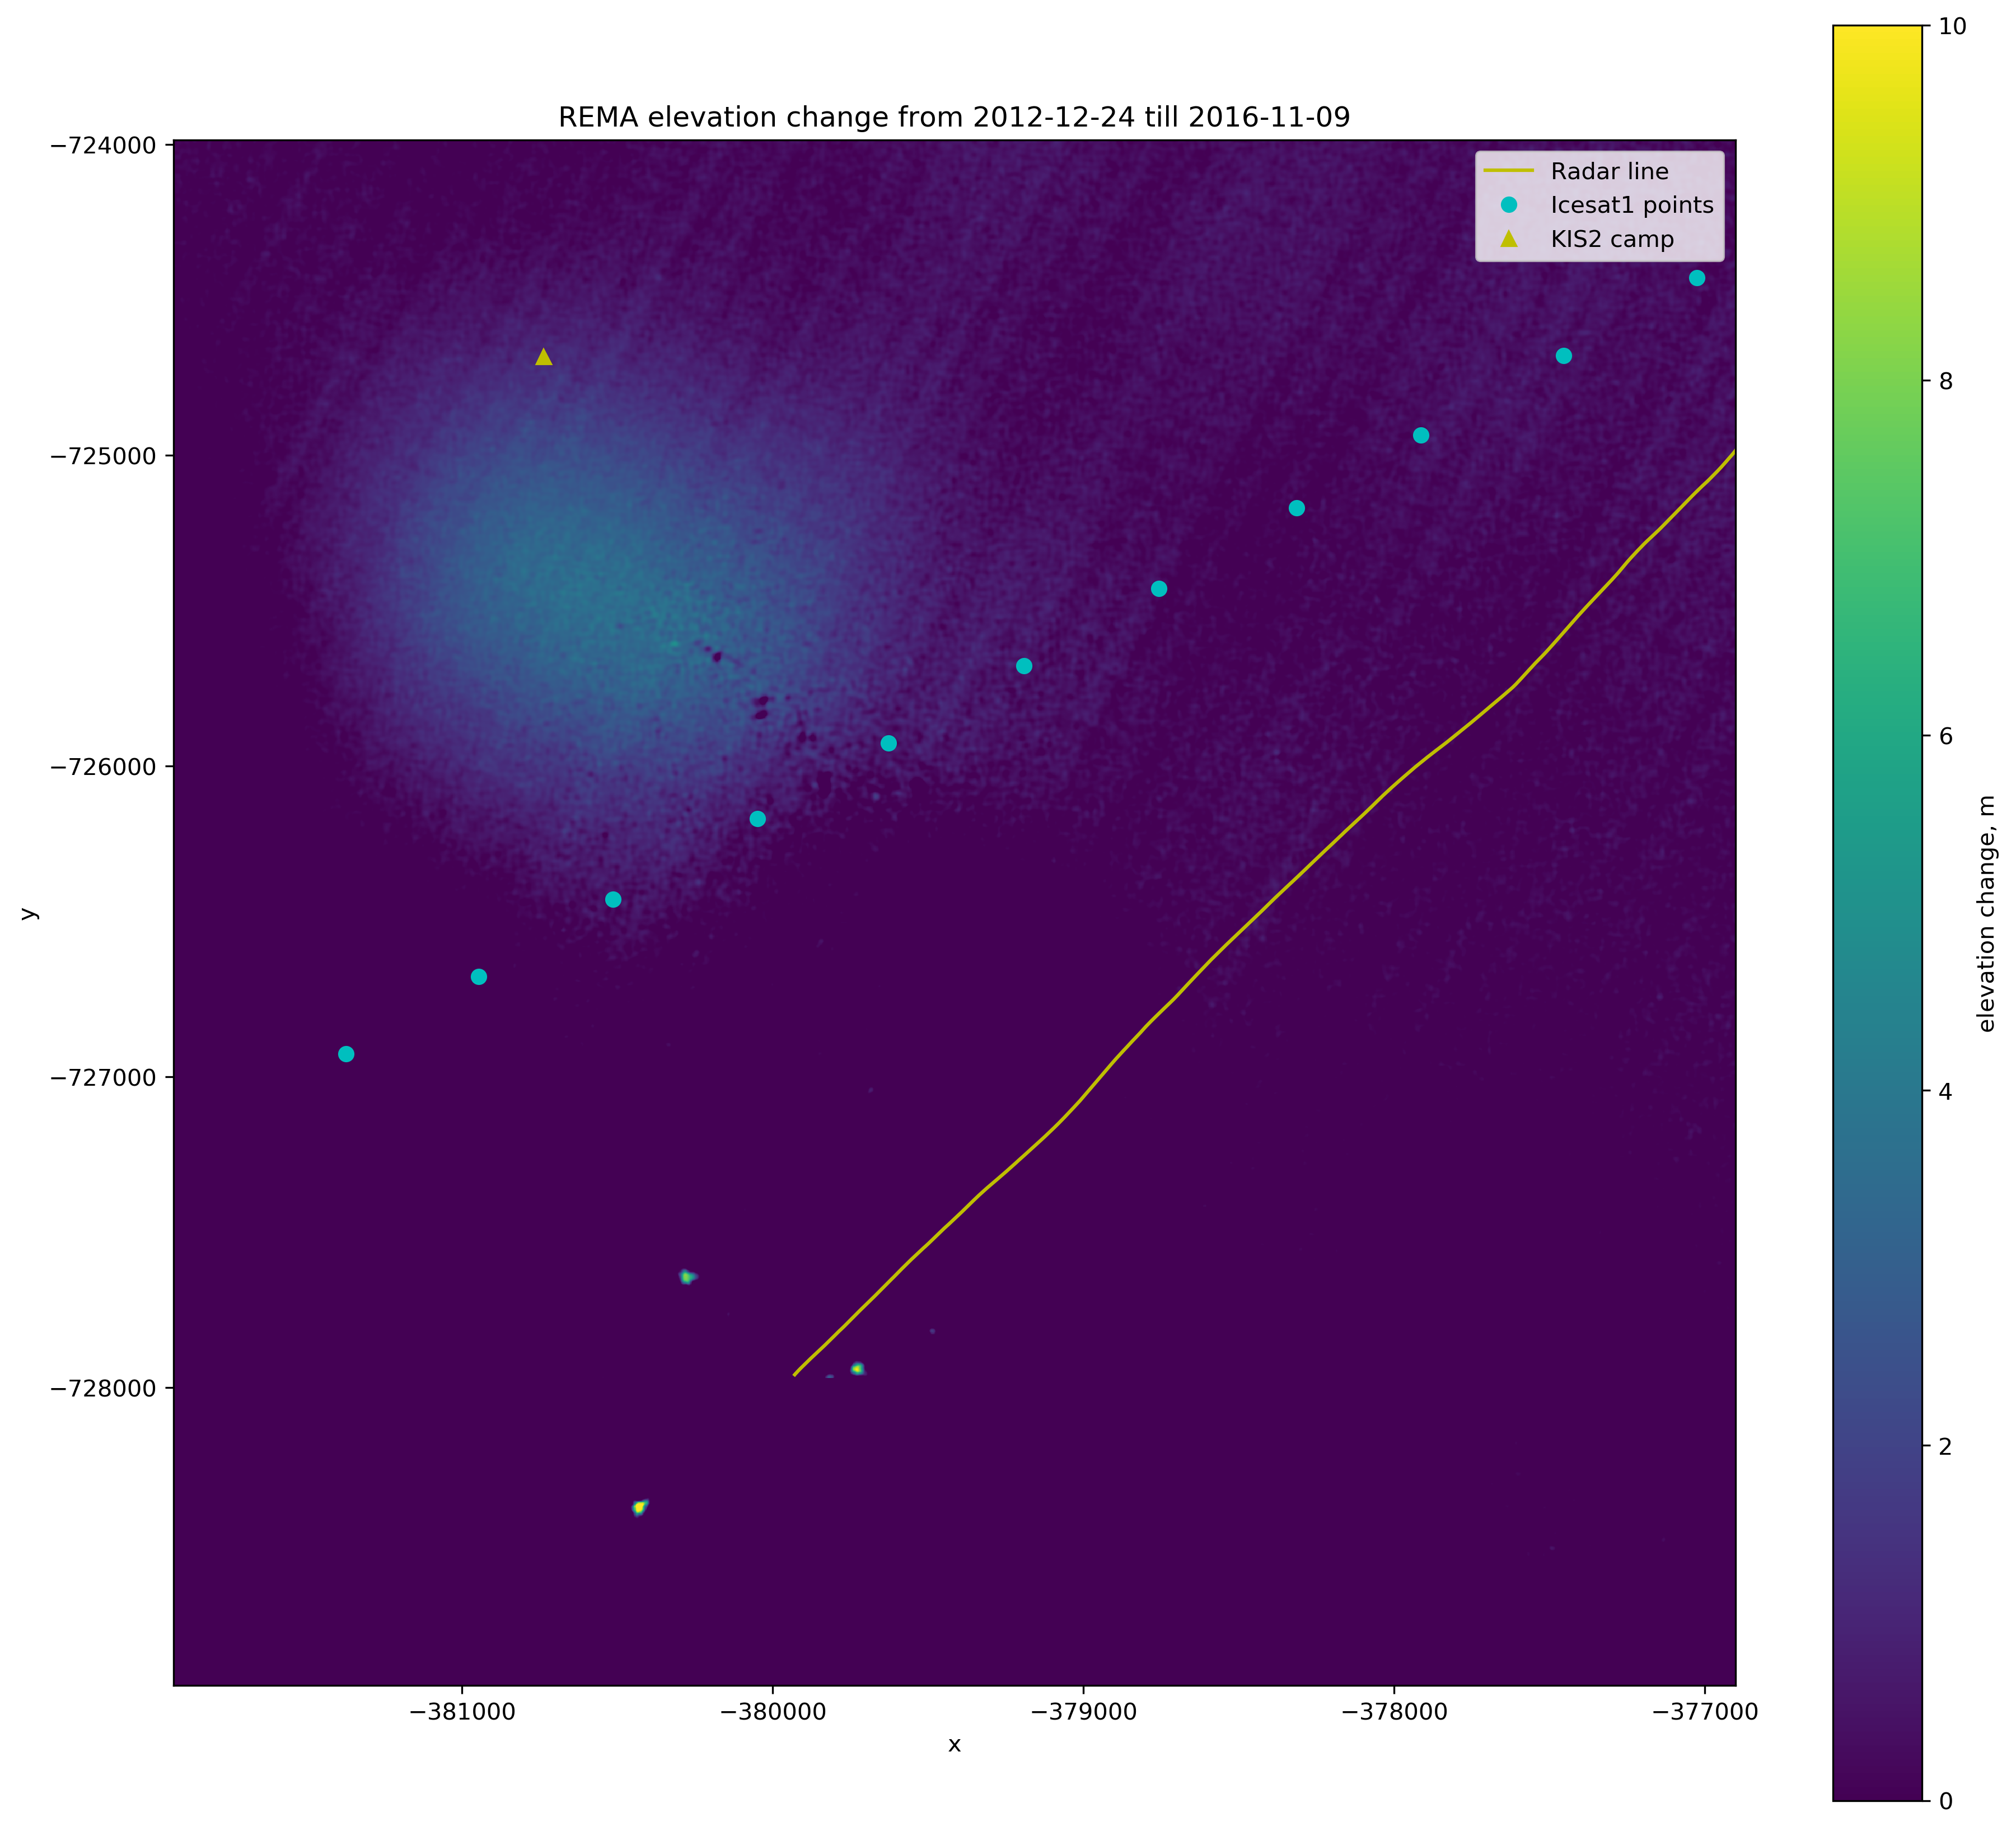

In [65]:

nid1 = 159202
nid2 = 131226
kis2 = [-380737.537026,-724683.311299]
line_name = 'lineAPREScross'
v=[0,10]
df_R = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp')

path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
image = rio.open(path)

extent = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
gdf_R = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/"
                    +line_name+".shp")
f = df_R.loc[nid1].acquisitio
t =df_R.loc[nid2].acquisitio
xmin,xmax = [gdf_R.geometry.x.to_numpy().min(),gdf_R.geometry.x.to_numpy().max()]
ymin,ymax = [gdf_R.geometry.y.to_numpy().min(),gdf_R.geometry.y.to_numpy().max()]
plt.figure(figsize=(15,14),dpi=300)
plt.imshow(image.read(1),extent=extent, vmin=v[0],vmax=v[1])
plt.xlim([xmin-2000, xmax])
plt.ylim([ymin-1000,ymax+1000])
cb = plt.colorbar()
plt.plot(gdf_R.geometry.x,gdf_R.geometry.y,'y')
plt.plot(cross_chan.x,cross_chan.y,'oc')
plt.plot(kis2[0],kis2[1],'y^')
plt.title(f'REMA elevation change from {f} till {t}')
cb.set_label('elevation change, m')
plt.legend(['Radar line','Icesat1 points','KIS2 camp'])
plt.xlabel('x')
plt.ylabel('y')

find out when dates are, and if this is all the data